# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.dummy import DummyClassifier

import time
from tqdm import tqdm

## Откройте и изучите файл

In [3]:
data = pd.read_csv('/datasets/users_behavior.csv')

display(data.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  
*сalls* — количество звонков,  
*minutes* — суммарная длительность звонков в минутах,  
*messages* — количество sms-сообщений,  
*mb_used* — израсходованный интернет-трафик в Мб,  
*is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  

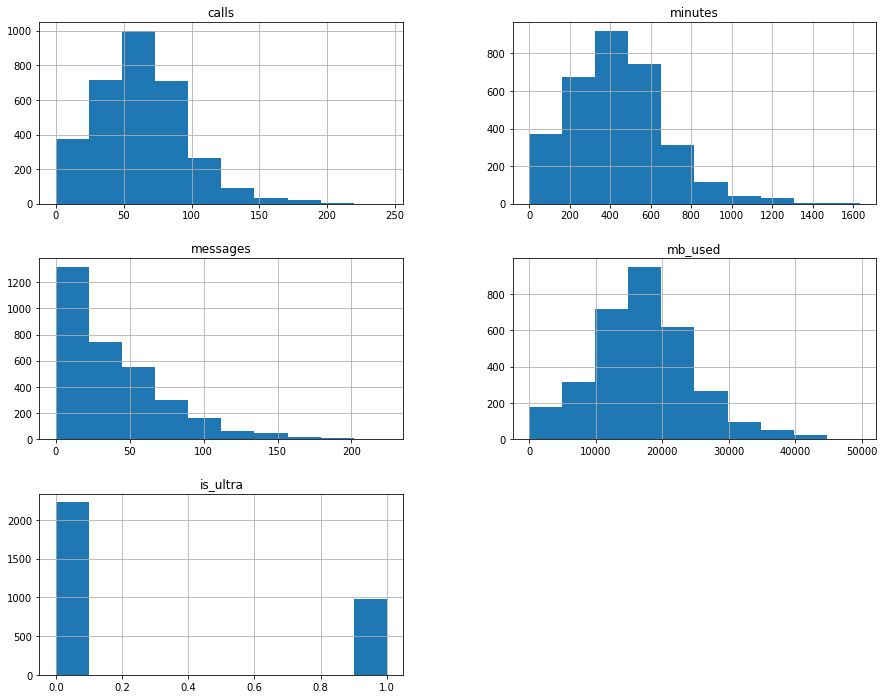

In [5]:
data.hist(figsize=(15,12))
plt.show()

**Вывод:**
- всего мы имеем `3214` строк данных, пропущенных значений нет
- количество пользователей на тарифах "Смарт" и "Ультра" отличаются. Тарифом "Ультра" пользуется меньше людей



## Разбейте данные на выборки

Т.к. нету скрытой тестовой выборки, мне нужно разделить данные на 5 частей, 3 пойдут на обучение модели, 1 на тест и 1 на валидацию. Получается я могу сначала взять 20% от общей, это получится валидационная выборка. Потом от остатка взять 25% это будет тестовая (это 1/4 от 80%). Так получается 3:1:1.

In [6]:
#разделяю данные на обучающие и целевые

features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

# Отделяю 20% данных под валидацию

features_rest, features_valid, target_rest, target_valid = train_test_split(
   features, target, test_size=0.20, random_state=12345)

# теперь разделяю остаток 1 к 4 на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(
   features_rest, target_rest, test_size=0.25, random_state=12345)



Данные разделены, теперь можно приступать к исследованию

In [ ]:
#Kод ревьюера
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'is_ultra', 
                                                                            train_size=0.6, valid_size=0.2, test_size=0.2)


## Исследуйте модели

**Дерево решений**

In [7]:
# Создаю таблицу для записи полученных значений
table_tree = pd.DataFrame({'max_depth':[], 'accuracy':[]})
#Решающее дерево

table_tree.drop(table_tree.index,inplace=True)


for depth in tqdm(range(1, 16)):
    table_row = []
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) # обучаем модель
    
    predictions_valid = model.predict(features_valid) # предсказывание даных
    
    accuracy = accuracy_score(target_valid, predictions_valid) # смотрим точность
    #accuracy = model.score(features_valid, target_valid)
    table_row.extend([depth, accuracy]) # добавляем к строке данные
    table_tree.loc[len(table_tree.index)] = table_row # заполняем таблицу
    
    
display(table_tree)

100%|██████████| 15/15 [00:00<00:00, 84.12it/s]


,max_depth,accuracy
0,1.0,0.748056
1,2.0,0.783826
2,3.0,0.786936
3,4.0,0.786936
4,5.0,0.788491
5,6.0,0.779160
6,7.0,0.788491
7,8.0,0.780715
8,9.0,0.777605
9,10.0,0.771384


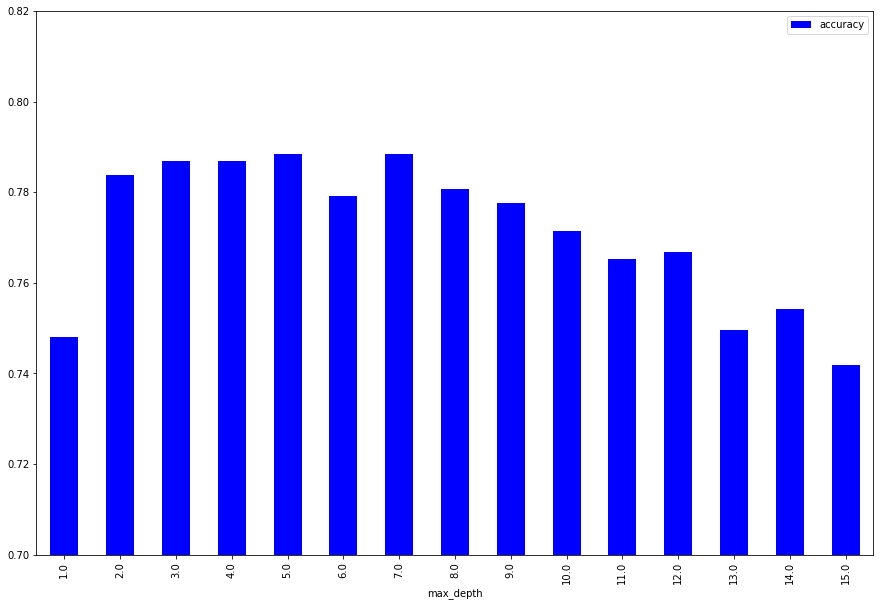

In [8]:
table_tree.plot.bar(x='max_depth', y='accuracy', ylim=(0.7, 0.82), figsize=(15,10), color='blue')
plt.show()

In [9]:
best_tree = table_tree[table_tree['accuracy'] == table_tree['accuracy'].max()].reset_index()

best_tree['model'] = 'decision tree'

best_tree

,index,max_depth,accuracy,model
0,4,5.0,0.788491,decision tree
1,6,7.0,0.788491,decision tree


**Случайный лес**

In [47]:
# Создаю таблицу для записи полученных значений
random_forest = pd.DataFrame({'n_estimators':[],'max_depth':[], 'accuracy':[]})
#Решающее дерево

random_forest.drop(random_forest.index,inplace=True)


for est in tqdm(range(10, 61, 10)):
    for depth in range (1, 11):
        table_row = []
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) # обучите модель на тренировочной выборке
        
        predictions_valid = model.predict(features_valid) # предсказывание даных
        accuracy = accuracy_score(target_valid, predictions_valid) # смотрим точность
        #accuracy = model.score(features_valid, target_valid)
    
        table_row.extend([est, depth, accuracy]) # добавляем к строке данные
        random_forest.loc[len(random_forest.index)] = table_row # заполняем таблицу
    
    
display(random_forest)

100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


,n_estimators,max_depth,accuracy
0,10.0,1.0,0.757387
1,10.0,2.0,0.780715
2,10.0,3.0,0.779160
3,10.0,4.0,0.780715
4,10.0,5.0,0.785381
5,10.0,6.0,0.791602
6,10.0,7.0,0.793157
7,10.0,8.0,0.793157
8,10.0,9.0,0.794712
9,10.0,10.0,0.788491


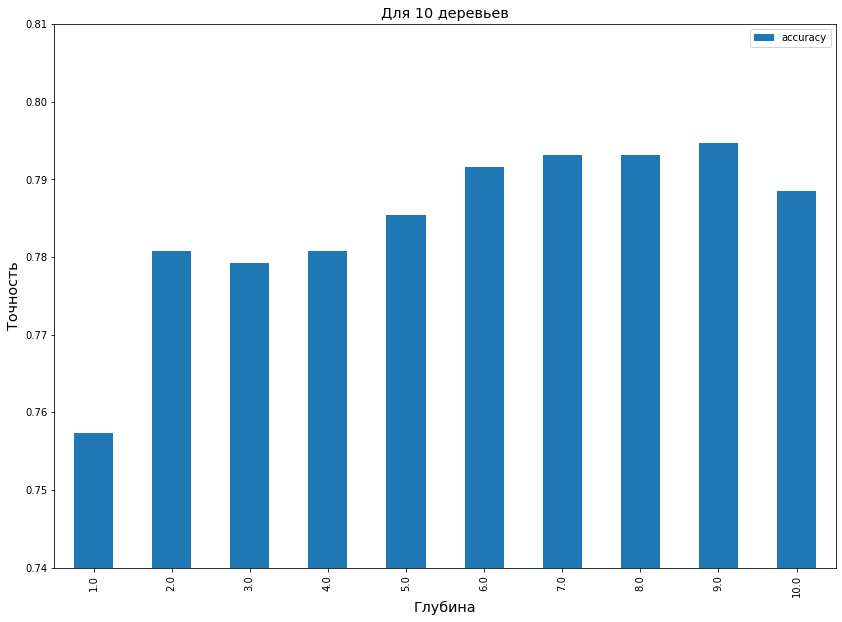

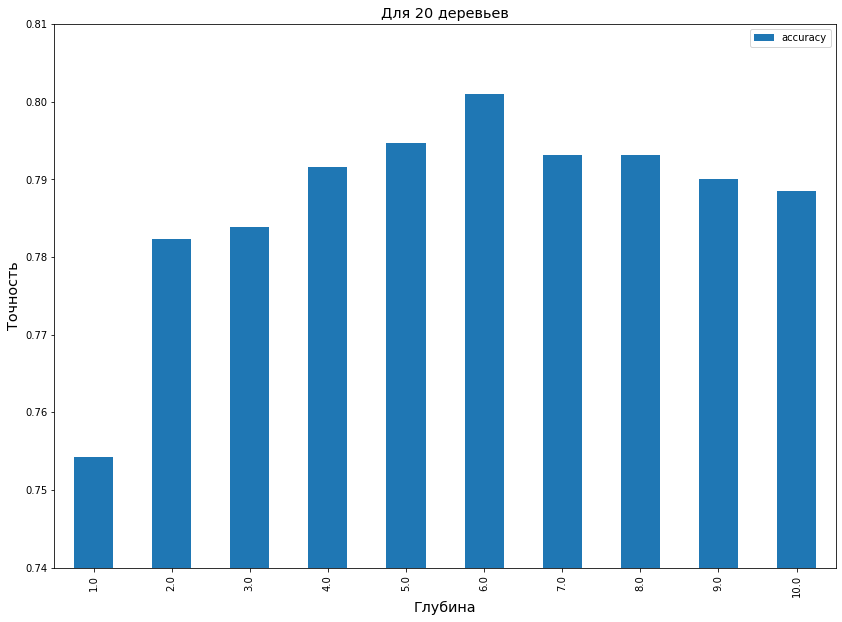

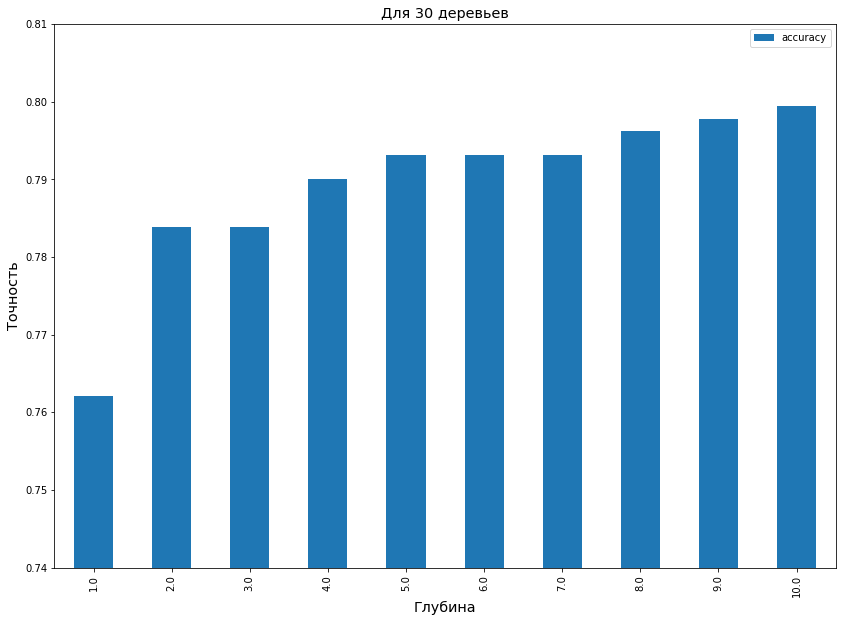

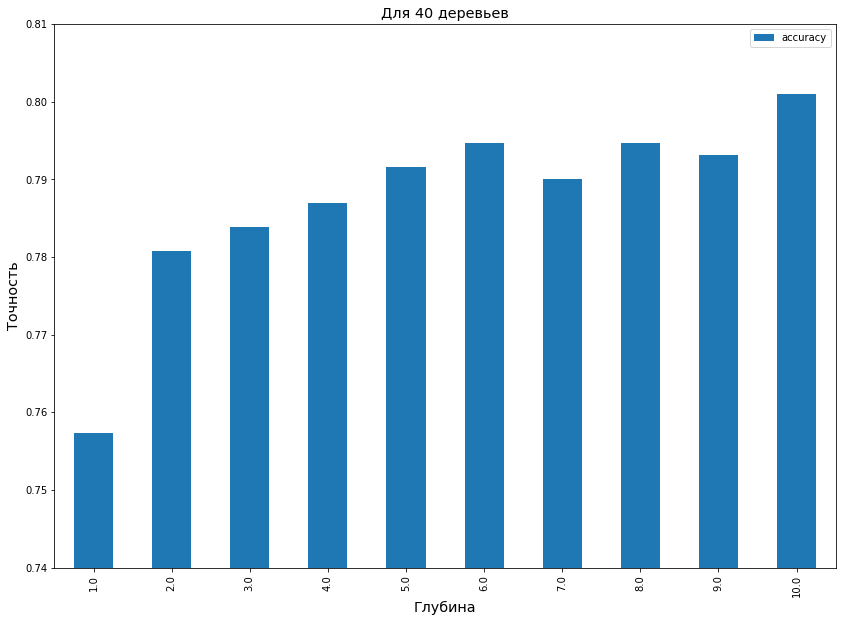

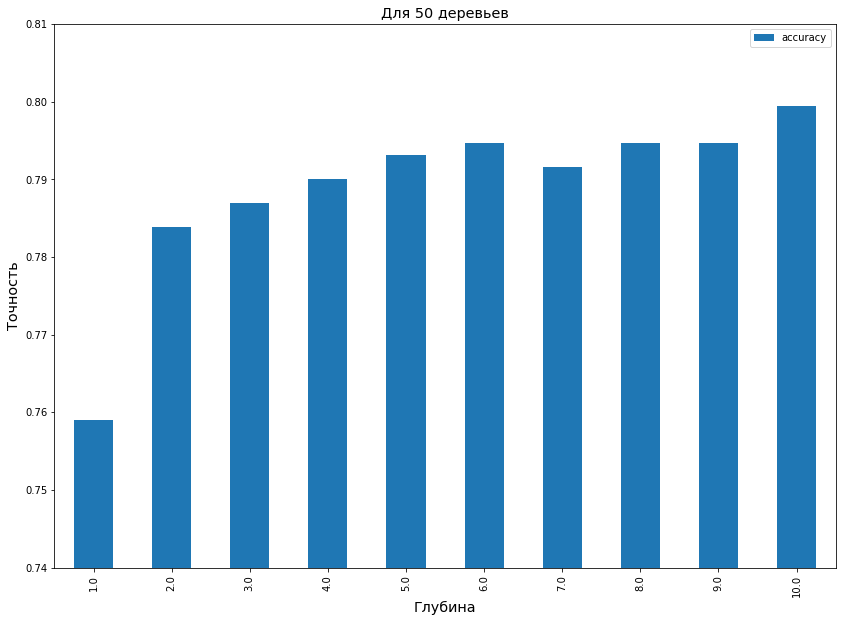

In [11]:
for x in range(10, 51, 10):
    random_forest
    random_forest[random_forest['n_estimators'] == x].plot.bar(x='max_depth', 
                                                               y='accuracy', 
                                                               ylim=(0.74, 0.81), 
                                                               figsize=(14,10), 
                                                               )
    plt.ylabel('Точность', fontsize='x-large')
    plt.xlabel('Глубина', fontsize='x-large')
    plt.title(f'Для {x} деревьев', fontsize='x-large')
    plt.show()

In [12]:
best_forest = random_forest[random_forest['accuracy'] == random_forest['accuracy'].max()].reset_index()

best_forest['model'] = 'random forest'

best_forest

,index,n_estimators,max_depth,accuracy,model
0,15,20.0,6.0,0.800933,random forest
1,39,40.0,10.0,0.800933,random forest


Получил одинаковую максимальную точность для кол-ва деревьев `20` и глубине `6`, такая же точность у `40` деревьев при глубине `10`.
Выбор останется за меньшим кол-вом, т.к. оно будет быстрей работать

**Логистическая регрессия**

In [13]:

model = LogisticRegression(random_state=12345)  # инициализируйте модель LinearRegression
model.fit(features_train, target_train) # обучите модель на тренировочной выборке
predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке

accuracy_log = accuracy_score(target_valid, predictions_valid)
print('При логистической регрессии точность составляет:', accuracy )

При логистической регрессии точность составляет: 0.7978227060653188


In [14]:
table_log = pd.DataFrame({'model': ['logistic regression'], 'accuracy': accuracy_log})

table_log

,model,accuracy
0,logistic regression,0.758942


**Список всех моделей**


In [34]:
best_model = pd.DataFrame({'model':[], 'n_estimators':[], 'max_depth':[], 'accuracy':[]})

best_model = best_model.append(best_tree, ignore_index=True)
best_model = best_model.append(best_forest, ignore_index=True)
best_model = best_model.append(table_log, ignore_index=True)
best_model = best_model.drop(labels = 'index', axis = 1)

display(best_model.sort_values(by = 'accuracy', ascending = False))

#best_model.plot.bar(x='model',y='accuracy',ylim=(0.74, 0.81),figsize=(14,10))

,model,n_estimators,max_depth,accuracy
2,random forest,20.0,6.0,0.800933
3,random forest,40.0,10.0,0.800933
0,decision tree,NaN,5.0,0.788491
1,decision tree,NaN,7.0,0.788491
4,logistic regression,NaN,NaN,0.758942


**Вывод:**  
Самая высокая точность у модели `Случайный лес`. Для тестирования возьму с числом деревьев `20` и глубиной `6`, т.к. это будет быстрее работать при том же результате.

## Проверьте модель на тестовой выборке

In [36]:
# Возьму модель Случайного леса и укажу лучшие параметры

model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=6)
model.fit(features_train, target_train) # обучите модель на тренировочной выборке
        
predictions_random_forest = model.predict(features_test) # предсказывание даных
accuracy_random_forest = accuracy_score(target_test, predictions_random_forest) # смотрим точность

accuracy_random_forest

0.7853810264385692

**Вывод**

Точность на тестовой выбоке составила 78%

## (бонус) Проверьте модели на адекватность

Для прверки модели, сравним её с базовым уровнем. Для этого используем модель фиктивного классификатора `Dummy Classifier`. Это модель классификатора, которая делает прогнозы, не пытаясь найти закономерности в данных. Модель по умолчанию рассматривает, какая метка наиболее часто встречается в обучающем наборе данных, и делает прогнозы на основе этой метки.

In [46]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')

dummy_clf.score(features_test, target_test)

0.6889580093312597

Точность `Dummy Classifier` составила 68%. Учитывая, что он не пытается найти никакую закономерность в данных, можно жно сказать, что модель случайного леса справилась нормально.